In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixtureModel(BaseModel):
    LINK = "mixture_model"

    def __init__(self, config: Config):
        super(MixtureModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(10))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(10))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(loc=50, scale=50, low=0))
                a_scale = numpyro.sample("a_scale", dist.HalfNormal(scale=100))

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.sample(site.a, dist.TruncatedNormal(loc=a_mean, scale=a_scale, low=0))

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(5))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/proc-2023-11-13/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "experiments/sparse-subjects/learn-posterior")
config.RESPONSE = ["PKPK_APB"]
config.FEATURES = ["intervention"]

config.MCMC_PARAMS["num_warmup"] = 1000
config.MCMC_PARAMS["num_samples"] = 1000

model = MixtureModel(config=config)

2023-11-17 16:45:24,109 - hbmep.config - INFO - Verifying configuration ...
2023-11-17 16:45:24,110 - hbmep.config - INFO - Success!
2023-11-17 16:45:24,126 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/proc-2023-11-15.csv"
df = pd.read_csv(src)

df[model.features[0]] = 0

df, encoder_dict = model.load(df=df)


2023-11-17 16:45:38,822 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/proc-2023-11-13/experiments/sparse-subjects/learn-posterior
2023-11-17 16:45:38,822 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/proc-2023-11-13/experiments/sparse-subjects/learn-posterior
2023-11-17 16:45:38,823 - hbmep.dataset.core - INFO - Processing data ...
2023-11-17 16:45:38,824 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-17 16:45:40,491 - hbmep.model.baseline - INFO - Running inference with base_model ...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0

prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-17 15:22:42,371 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-11-17 15:22:45,984 - hbmep.utils.utils - INFO - func:predict took: 3.61 sec
2023-11-17 15:22:45,985 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-17 15:22:48,799 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/proc-2023-11-13/experiments/sparse-subjects/learn-posterior/recruitment_curves.pdf
2023-11-17 15:22:48,799 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 2.81 sec
2023-11-17 15:22:48,799 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-17 15:22:52,163 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/proc-2023-11-13/experiments/sparse-subjects/learn-posterior/posterior_predictive_check.pdf
2023-11-17 15:22:52,163 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 3.36 sec
2023-11-17 15:22:52,163 - hbmep.util

In [36]:
dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)

print(dest)

/home/vishu/repos/hbmep-paper/reports/paper/tms/proc-2023-11-13/experiments/sparse-subjects/learn-posterior/inference.pkl


In [37]:
dest = os.path.join(model.build_dir, "inference.nc")
az.to_netcdf(mcmc, dest)
dest

'/home/vishu/repos/hbmep-paper/reports/paper/tms/proc-2023-11-13/experiments/sparse-subjects/learn-posterior/inference.nc'

In [32]:
a = posterior_samples["a"]
a.shape

a_map = a.mean(axis=0)
a_map.shape

import scipy.stats as stats

stats.ttest_ind(
    a=a_map[:10, 0, 0],
    b=a_map[10:, 1, 0],
    alternative="less"
)


TtestResult(statistic=-2.0859897656189625, pvalue=0.02723544173591708, df=15.0)

0.798

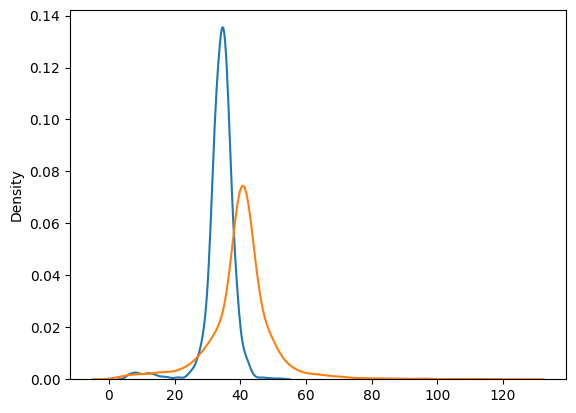

In [34]:
a_mean = posterior_samples["a_mean"]

import seaborn as sns

sns.kdeplot(a_mean[:, 0, 0])
sns.kdeplot(a_mean[:, 1, 0])
prob = (a_mean[:, 1, 0] - a_mean[:, 0, 0] > 0).mean()
prob


In [31]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")

2023-11-17 16:42:21,813 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-17 16:42:25,910 - __main__ - INFO - ELPD LOO (Log): 1309.61
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities

In [30]:
import scipy.stats as stats

a = posterior_samples["a"]
a_map = a.mean(axis=0)

stats.ttest_ind(
    a=a_map[:10, 0, 0], b=a_map[10:, 1, 0], alternative="less"
)


TtestResult(statistic=-2.0859897656189625, pvalue=0.02723544173591708, df=15.0)